In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore')

In [216]:
data = pd.read_csv('data/tested_molecules.csv')
    
# Generate descriptors for each molecule
descriptor_list = [d[0] for d in Descriptors._descList]
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_list)


# function to get the descriptor for each molecule in SMILES
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return calculator.CalcDescriptors(mol)
    return [None] * len(descriptor_list)


def evaluate_model(model, X_val, y_val, label, threshold=0.5, print_info=False):
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_proba > threshold).astype(int)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    if print_info:
        # Manually plotting the confusion matrix
        cm = np.array([[tn, fp], [fn, tp]])
        fig, ax = plt.subplots(figsize=(8, 6))
        cax = ax.matshow(cm, cmap='Blues')
        plt.title(f'Confusion Matrix for {label}')
        fig.colorbar(cax)
        ax.set_xticklabels([''] + ["No inhibition", "Inhibition"])
        ax.set_yticklabels([''] + ["No inhibition", "Inhibition"])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.grid(False)
        # Annotate confusion entries
        for (i, j), val in np.ndenumerate(cm):
            ax.text(j, i, f'{val}', ha='center', va='center', color='k')
        plt.show()
    if print_info:
        print(f"{label} Model Performance:")
        print(f"Precision: {precision * 100:.4f}%, Recall: {recall * 100:.4f}%")
        print(f"Accuracy: {accuracy * 100:.4f}%")
        print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
        print("-" * 30)
    return precision, recall, accuracy, tn, fp, fn, tp

In [217]:
# SMILES contain the molecules, so apply the calculate_descriptors on SMILES
data['Descriptors'] = data['SMILES'].apply(compute_descriptors)
descriptors_df = pd.DataFrame(data['Descriptors'].tolist(), columns=descriptor_list)
data = pd.concat([data, descriptors_df], axis=1)

# Drop rows with NaN values
data.dropna(inplace=True)

The variance in the first prinicpal component is 18%


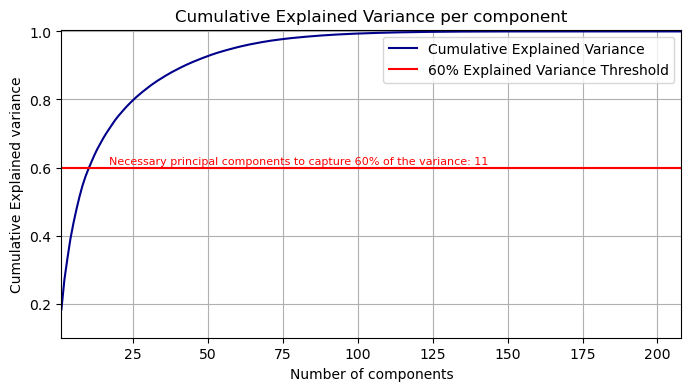

In [218]:
scaled_descriptors = MinMaxScaler().fit_transform(descriptors_df)
scaled_descriptors_df = pd.DataFrame(scaled_descriptors, columns=descriptors_df.columns)

principal_components = PCA(n_components=208)
principal_components.fit(scaled_descriptors_df)
pca_transformed = principal_components.transform(scaled_descriptors_df)
# Determine variance and cumulative variance
variance = principal_components.explained_variance_ratio_
sum_variance = np.zeros(len(variance)) # Initialize an array for cumulative variance
for i in range(len(variance)):
    sum_variance[i] = sum(variance[0:i+1])

# Determine the amount of principal components to capture 60% variance
threshold_component = np.where(sum_variance > 0.60)[0][0] # Component at which the cumulative variance is higher than 0.6

# Variance in the first component
first_component = sum_variance[0]*100
print(f'The variance in the first prinicpal component is {first_component:.0f}%')

plt.figure(figsize=(8,4))
plt.plot(range(1,len(variance)+1),sum_variance , color='darkblue')
plt.text(threshold_component+7, 0.61, f'Necessary principal components to capture 60% of the variance: {threshold_component+1}', fontsize=8, color='r')
plt.axhline(y=0.6, color='r')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained variance')
plt.ylim(0.1,1.005)
plt.legend(['Cumulative Explained Variance', '60% Explained Variance Threshold'])
plt.xlim(1,208)
plt.grid()
plt.title('Cumulative Explained Variance per component')
plt.show()

In [220]:
# Extract the eigenvalues from the first principal component
top_descriptors = []
for i in range(11):
    pca_eigenvalue = principal_components.components_[i]
    absolute_eigenvalue = np.abs(pca_eigenvalue)
    df_eigenvalues = pd.DataFrame(absolute_eigenvalue, columns=['Eigenvalue']) # Create dataframe for visualisation
    df_eigenvalues['Descriptor'] = scaled_descriptors_df.columns # Add the features
    df_sort = df_eigenvalues.sort_values(by='Eigenvalue', ascending=False) # Sort them on eigenvalue
    #print(df_sort.head(10)) # Print the top 10 eigenvalues

    top_5_descriptors = df_sort['Descriptor'].head(5).tolist() # Get the top 5 descriptors
    top_descriptors.extend(top_5_descriptors) # Add them to the list

# Remove duplicates
top_descriptors = list(set(top_descriptors))

# Display the DataFrame as a table
print(top_descriptors)
print(len(top_descriptors))


['SlogP_VSA10', 'BCUT2D_LOGPHI', 'PEOE_VSA12', 'NumRotatableBonds', 'VSA_EState10', 'BCUT2D_MRHI', 'LabuteASA', 'MinEStateIndex', 'NHOHCount', 'NumSaturatedHeterocycles', 'fr_sulfonamd', 'SlogP_VSA11', 'fr_amide', 'fr_benzene', 'fr_aniline', 'fr_sulfide', 'NumHDonors', 'SMR_VSA7', 'VSA_EState2', 'SlogP_VSA12', 'BCUT2D_MRLOW', 'VSA_EState6', 'EState_VSA4', 'BCUT2D_MWHI', 'fr_quatN', 'fr_Ar_N', 'SlogP_VSA6', 'fr_NH0', 'PEOE_VSA13', 'SMR_VSA5', 'NumAromaticCarbocycles', 'EState_VSA6', 'fr_NH1', 'NumAromaticHeterocycles', 'NumAromaticRings', 'Kappa1', 'VSA_EState3', 'MolWt', 'BCUT2D_LOGPLOW', 'HeavyAtomMolWt', 'ExactMolWt', 'PEOE_VSA2', 'PEOE_VSA3', 'Kappa3', 'SMR_VSA3', 'PEOE_VSA1', 'fr_bicyclic']
47


In [221]:
X = scaled_descriptors_df[top_descriptors]

y_pkm2 = data['PKM2_inhibition'].values
y_erk2 = data['ERK2_inhibition'].values

X_train, X_val, y_train_pkm2, y_val_pkm2 = train_test_split(X, y_pkm2, test_size=0.2, random_state=42)
X_train_erk2, X_val_erk2, y_train_erk2, y_val_erk2 = train_test_split(X, y_erk2, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote_pkm2, y_train_smote_pkm2 = smote.fit_resample(X_train, y_train_pkm2)
X_train_smote_erk2, y_train_smote_erk2 = smote.fit_resample(X_train, y_train_erk2)

In [222]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 10, 25, 50]
}

In [223]:
xgb_pkm2 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search_pkm2 = GridSearchCV(estimator=xgb_pkm2, param_grid=param_grid, scoring='precision', cv=5, verbose=1, n_jobs=-1)
grid_search_pkm2.fit(X_train_smote_pkm2, y_train_smote_pkm2)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mono...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                    

In [224]:
xgb_erk2 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search_erk2 = GridSearchCV(estimator=xgb_erk2, param_grid=param_grid, scoring='precision', cv=5, verbose=1, n_jobs=-1)
grid_search_erk2.fit(X_train_smote_erk2, y_train_smote_erk2)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mono...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                    

In [225]:
print(f"number of 1s in y_val_PKM2 {np.count_nonzero(y_val_pkm2 == 1)}")
print(f"number of 1s in y_val_ERK2 {np.count_nonzero(y_val_erk2 == 1)}")

number of 1s in y_val_PKM2 6
number of 1s in y_val_ERK2 16


Finding best values


Evaluating thresholds: 100%|██████████| 1000/1000 [00:15<00:00, 63.76it/s]


PKM2: ------------------------------
Best Threshold: 0.013963963963963964
Best Recall: 0.5
Best Accuracy: 0.9241071428571429
Best Precision: 0.17647058823529413
Best FN: 3

ERK2: ------------------------------
Best Threshold: 0.7008928571428571
Best Recall: 0.6875
Best Accuracy: 0.7008928571428571
Best Precision: 0.1506849315068493
Best FN: 5


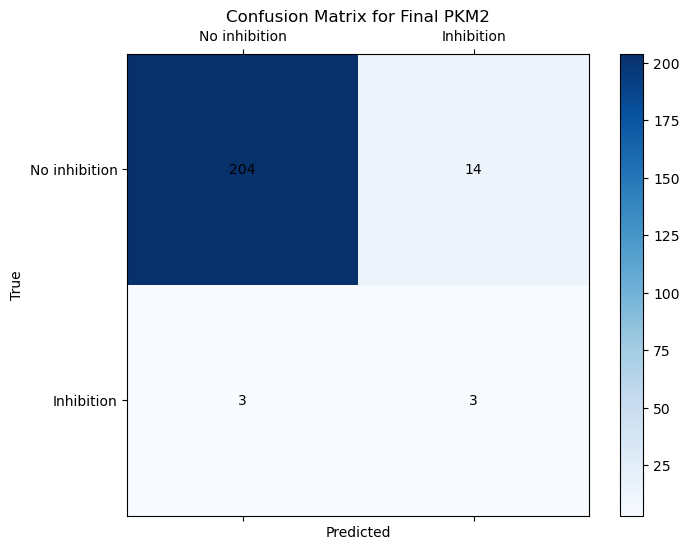

Final PKM2 Model Performance:
Precision: 17.6471%, Recall: 50.0000%
Accuracy: 92.4107%
TP: 3, TN: 204, FP: 14, FN: 3
------------------------------


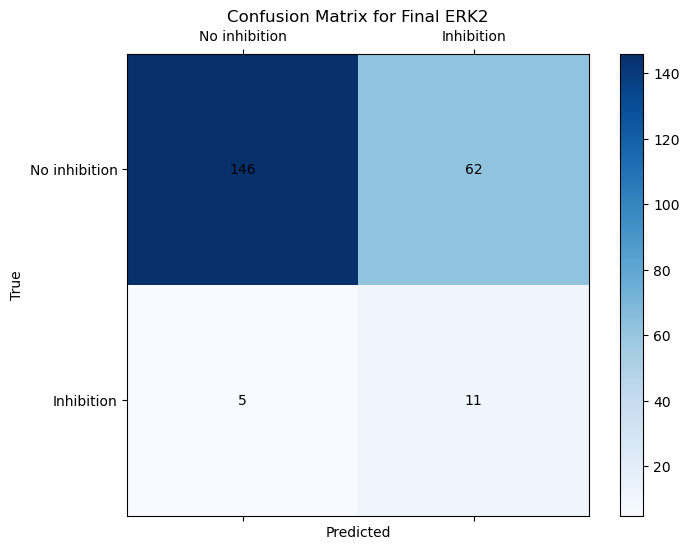

Final ERK2 Model Performance:
Precision: 15.0685%, Recall: 68.7500%
Accuracy: 70.0893%
TP: 11, TN: 146, FP: 62, FN: 5
------------------------------


(0.1506849315068493, 0.6875, 0.7008928571428571, 146, 62, 5, 11)

In [226]:
best_model_pkm2 = grid_search_pkm2.best_estimator_
best_model_erk2 = grid_search_erk2.best_estimator_

thresholds = np.linspace(0.01, 1.0, 1000)
best_threshold_pkm2, best_recall_pkm2, best_precision_pkm2, best_accuracy_pkm2 = 0.5, 0, 0, 0
best_threshold_erk2, best_recall_erk2, best_precision_erk2, best_accuracy_erk2 = 0.5, 0, 0, 0
fn_pkm2, fn_erk2 = float('inf'), float('inf')

print("Finding best values")

for threshold in tqdm(thresholds, desc="Evaluating thresholds"):
    precision, recall, accuracy, _, _, fn, _ = evaluate_model(best_model_pkm2, X_val, y_val_pkm2, f"PKM2 (Threshold: {threshold:.2f})", threshold)
    if recall >= best_recall_pkm2 and precision >= best_precision_pkm2 and accuracy >= best_accuracy_pkm2 and fn <= fn_pkm2:
        best_recall_pkm2 = recall
        best_threshold_pkm2 = threshold
        best_precision_pkm2 = precision
        best_accuracy_pkm2 = accuracy
        fn_pkm2 = fn
    
    precision, recall, accuracy, _, _, fn, _ = evaluate_model(best_model_erk2, X_val_erk2, y_val_erk2, f"ERK2 (Threshold: {threshold:.2f})", threshold)
    if recall >= best_recall_erk2 and precision >= best_precision_erk2 and accuracy >= best_accuracy_erk2 and fn <= fn_erk2:
        best_recall_erk2 = recall
        best_threshold_erk2 = threshold
        best_precision_erk2 = precision
        best_accuracy_erk2 = accuracy
        fn_erk2 = fn

print(f"PKM2: {'-' * 30}\n"
      f"Best Threshold: {best_threshold_pkm2}\n"
      f"Best Recall: {best_recall_pkm2}\n"
      f"Best Accuracy: {best_accuracy_pkm2}\n"
      f"Best Precision: {best_precision_pkm2}\n"
      f"Best FN: {fn_pkm2}\n")
print(f"ERK2: {'-' * 30}\n"
      f"Best Threshold: {best_accuracy_erk2}\n"
      f"Best Recall: {best_recall_erk2}\n"
      f"Best Accuracy: {best_accuracy_erk2}\n"
      f"Best Precision: {best_precision_erk2}\n"
      f"Best FN: {fn_erk2}\n\n")

evaluate_model(best_model_pkm2, X_val, y_val_pkm2, "Final PKM2", best_threshold_pkm2, True)
evaluate_model(best_model_erk2, X_val_erk2, y_val_erk2, "Final ERK2", best_threshold_erk2, True)

In [232]:
test_data = pd.read_csv('data/untested_molecules-3.csv')
X_test = np.array([compute_descriptors(smiles) for smiles in test_data['SMILES']])
X_test = pd.DataFrame(X_test, columns=descriptor_list)
X_test = X_test[top_descriptors]

test_data['PKM2_inhibition'] = (best_model_pkm2.predict_proba(X_test)[:, 1] > best_threshold_pkm2).astype(int)
test_data['ERK2_inhibition'] = (best_model_erk2.predict_proba(X_test)[:, 1] > best_threshold_erk2).astype(int)

In [233]:
test_data[test_data['PKM2_inhibition'] == 1]

,SMILES,PKM2_inhibition,ERK2_inhibition
1,O=C(CCN1C(=O)COc2ccccc21)NCc1cccs1,1,0
11,CN(C)c1ccc(-c2noc(C3CCN(S(=O)(=O)c4cccc(Cl)c4)...,1,0
13,COC(=O)[C@@]1(Cc2ccc(OC)cc2)[C@H]2c3cc(C(=O)N4...,1,0
15,CCN1/C(=C/C(=O)c2ccco2)Sc2ccccc21,1,1
18,COc1ccccc1NC(=O)N1CCN(c2cc(-c3ccccc3)nc3ncnn23...,1,0
...,...,...,...
4442,COc1cccc(N2C(=O)NC(=O)[C@@]3(Cc4cc(C)ccc4N(C)C...,1,0
4447,C[C@@H]1CCCN(C(=O)COC(=O)c2n[nH]c3ccccc23)C1,1,0
4448,Cc1cccc(Nc2nn3c(=O)c4ccccc4nc3s2)c1,1,1
4450,Cn1c(SCc2ccc(F)cc2)nnc1-c1ccccn1,1,1


In [234]:
test_data[test_data['ERK2_inhibition'] == 1] 

,SMILES,PKM2_inhibition,ERK2_inhibition
5,CCOc1ncccc1C(=O)Oc1ccc2c(c1)OCO2,0,1
6,CSc1ccc(/C=N/n2c(C)cc(C)cc2=O)cc1,0,1
7,Cc1cc(N2CCCCC2)n2ncc(-c3ccccc3)c2n1,0,1
15,CCN1/C(=C/C(=O)c2ccco2)Sc2ccccc21,1,1
17,CC1=C/C(=C\c2ccc3c(c2)OCO3)C(=O)S1,0,1
...,...,...,...
4448,Cc1cccc(Nc2nn3c(=O)c4ccccc4nc3s2)c1,1,1
4449,Cc1cc(C)cc(Nc2ccc(C(=O)[O-])cc2N)c1,0,1
4450,Cn1c(SCc2ccc(F)cc2)nnc1-c1ccccn1,1,1
4451,CCOC(=O)c1ccc(Oc2nc(OC)nc(N(C)C)n2)cc1,0,1


In [236]:
test_data.to_csv('data/pred.csv', index=False)